In [3]:
import numpy as np 
import pandas as pd 
import os
import torch
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from PIL import Image
from nltk.stem import SnowballStemmer

In [55]:
assert torch.cuda.is_available(), "GPU is not enabled"

# use the first gpu available if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

AssertionError: GPU is not enabled

In [4]:
dataset_path = "C:/Users/Miguel/OneDrive/Escritorio/2n curs/2n Semestre/Neural Networks and Deep Learning/Project/dataset"
captions_path = dataset_path + "/captions.txt"
images_path = dataset_path + "/Images"

In [5]:
# READ THE CAPTIONS FILE.txt
df_captions = pd.read_csv(captions_path)

print(f"Number of captions: {len(df_captions)}")
df_captions.head()

Number of captions: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


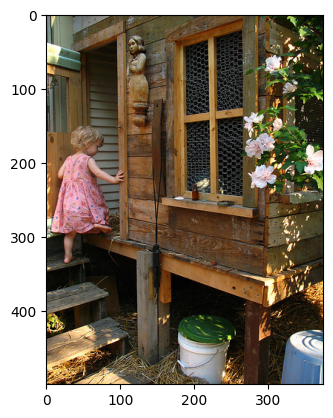

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [6]:
#VISUALIZE DATASET

# Select a random index 
idx = 0
image_path = images_path + "/" + df_captions.iloc[idx, 0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

# For each image we have 5 captions
for i in range(idx, idx+5):
    print("Caption:",df_captions.iloc[i,1])

In [19]:
class Vocabulary():
    def __init__(self, threshold):
        # Defining some needed tokens
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        
        # Reversed dictionary itos
        self.stoi = {v:k for k,v in self.itos.items()}
        self.threshold = threshold
    
    def __len__(self):
        return len(self.itos)
    
    def tokenize_and_low(self, text):
        return [token.lower() for token in word_tokenize(text)]
    
    def build_vocab(self, captions_list):
        freq = Counter()
        idx = 4 # In itos and stoi the next index is 4
        
        for caption in captions_list:
            for word in self.tokenize_and_low(caption):
                freq[word] += 1
                
                # Add word to vocabulary if reaches the threshold
                
                if freq[word] == self.threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
                    
    def __getindex__(self, text):
        tokenized_text = self.tokenize_and_low(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]                
                

In [20]:
# Let's test the class

# Define a threshold
vocab_test = Vocabulary(threshold = 1)

vocab_test.build_vocab(["I'm doing my deep learning project"])
print(vocab_test.stoi)
print(vocab_test.itos)
print(vocab_test.__getindex__("I'm doing my deep learning project about image captioning"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'i': 4, "'m": 5, 'doing': 6, 'my': 7, 'deep': 8, 'learning': 9, 'project': 10}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'i', 5: "'m", 6: 'doing', 7: 'my', 8: 'deep', 9: 'learning', 10: 'project'}
[4, 5, 6, 7, 8, 9, 10, 3, 3, 3]


In [21]:
class BuildDataset(Dataset):
    def __init__(self, dir, captions, transform=None, threshold=5):
        self.dir = dir
        self.df = pd.read_csv(captions)
        self.transform = transform
        
        self.images = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_name = self.images[idx]
        
        image_location = self.dir + "/" + image_name
        image = Image.open(image_location)
        
        if self.transform != None:
            image = self.transform(image)
        
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.__getindex__(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
            
        
        return image, torch.tensor(caption_vec)

In [22]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [33]:
# testing the dataset
dataset = BuildDataset(
        dir =images_path,
        captions = captions_path,
        transform = transforms
)


In [26]:
def show_image(tensor, title=None):
    """Imshow for Tensor"""
    tensor = tensor.numpy().transpose((1,2,0))
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

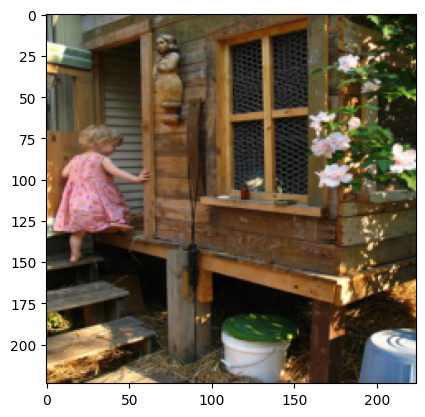

Token index: tensor([  1,   4,  28,   8,   4, 190, 148,  17,  32,  67,   4, 347,  11, 703,
          8,  24,   3, 492,   5,   2])
caption: ['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [38]:
img, caps = dataset[0]

show_image(img)
print("Token index:", caps)
print("caption:", [dataset.vocab.itos[token] for token in caps.tolist()])



In [25]:
# Opening images 
list_images_path = os.listdir(images_path)
for image_path in tqdm(list_images_path):
    img_path=images_path+'/'+image_path
    image=load_img(img_path,target_size=(224,224))
    

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html